In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scienceplots
import scipy
import scipy.stats
plt.style.use(['science', 'grid'])
import matplotlib
from matplotlib.ticker import FormatStrFormatter

from pathlib import Path
from scipy.optimize import curve_fit
from scipy import ndimage, misc
plt.rcParams["figure.figsize"] = (3.5, 2.5)
plt.rcParams["figure.dpi"] = 150
plt.rcParams["lines.linewidth"] = 0.5

In [2]:
folder = "optotune"
files = os.listdir(folder)
files.sort(key=lambda x: os.path.getctime(os.path.join(folder, x)))      
# files = files[1000::] >

In [3]:
class sample:
    def __init__(self, filename):
        properties = filename[0:-4].split("_")
        self.filename = filename
        self.number = int(properties[0])
        self.time = float(properties[1])
        self.command = float(properties[2])
        self.temperature = float(properties[3])
        self.pressure = float(properties[4])
        self.a_x = float(properties[5])
        self.a_y = float(properties[6])
        self.a_z = float(properties[7])
        self.a = np.sqrt(self.a_x ** 2 + self.a_y ** 2 + self.a_z ** 2)
        self.g_x = float(properties[8])
        self.g_y = float(properties[9])
        self.g_z = float(properties[10])
        self.m_x = float(properties[11])
        self.m_y = float(properties[12])
        self.m_z = float(properties[13])
        
    def load(self):
#         print(self.filename)
        return np.load(os.path.join(folder, self.filename))['arr_0']#[AOI_Y - AOI_SIZE:AOI_Y + AOI_SIZE,AOI_X - AOI_SIZE:AOI_X + AOI_SIZE]
    
    def spot_area(self):
        img = self.load()
        return np.sum(img > 8) # arbitrarily chosen
    
    def __repr__(self):
        return (f"n: {self.number} t: {self.time} cmd: {self.command} temp: {self.temperature} p: {self.pressure} a: {self.a}")
    
def plot_sample(sample):
    plt.imshow(ndimage.rotate(sample.load(), 23.6 + 180))

In [4]:
samples = [sample(x) for x in files]
t0 = samples[0].time

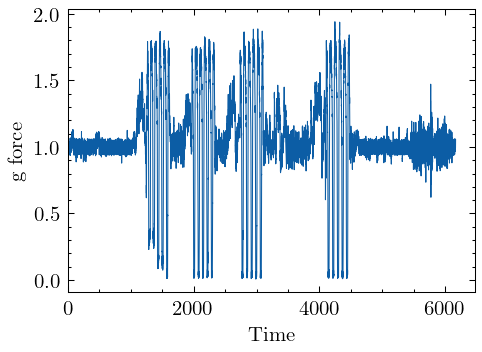

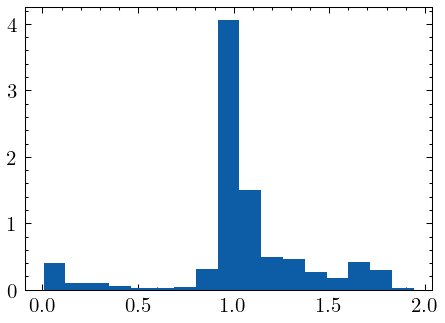

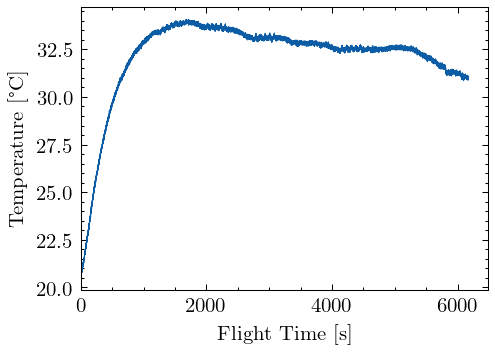

In [5]:
# print some acceleration data just so we know
accel_sample = list(map(lambda x: x.time - t0, samples))
accel = list(map(lambda x: x.a, samples))
plt.plot(accel_sample, accel)
plt.xlabel('Time')
plt.xlim(0)
plt.grid()
plt.ylabel('g force')
plt.show()
plt.hist(accel, density=True, bins=17)
plt.grid()
plt.show()
plt.plot([x.time - t0 for x in samples], [x.temperature for x in samples])
plt.grid()
plt.ylabel("Temperature [°C]")
plt.xlabel("Flight Time [s]")
plt.xlim(0)
plt.show()


# np.save("time_optotune.npy", [x.time - t0 for x in samples])
# np.save("temp_optotune.npy", [x.temperature for x in samples])

In [6]:
samples_0g = [x for x in samples if x.a < 0.3]
samples_1g = [x for x in samples if x.a < 1.1 and x.a > 0.9]
samples_hg = [x for x in samples if x.a > 1.5]

In [7]:
# plt.plot(list(map(lambda x: x.time, samples)), list(map(lambda x: x.pressure, samples)))

cmds_0g = [x.command for x in samples_0g]
spots_0g = [x.spot_area() for x in samples_0g]

cmds_hg = [x.command for x in samples_hg]
spots_hg = [x.spot_area() for x in samples_hg]

cmds_1g = [x.command for x in samples_1g]
spots_1g = [x.spot_area() for x in samples_1g]


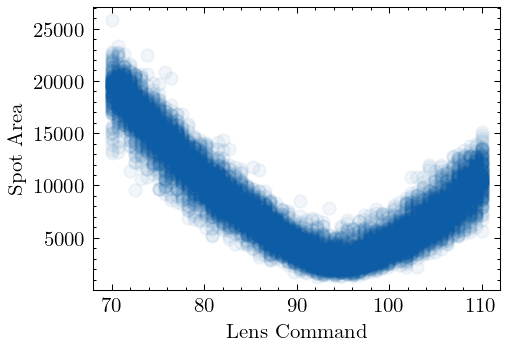

In [8]:
# plt.scatter(cmds_0g, spots_0g, alpha=0.4)
# plt.scatter(cmds_hg, spots_hg, alpha=0.4)
plt.scatter(cmds_1g, spots_1g, alpha=0.05)
plt.xlabel('Lens Command')
plt.ylabel('Spot Area')
plt.grid()
plt.show()

0g: 17, 1g: 164, hg: 26


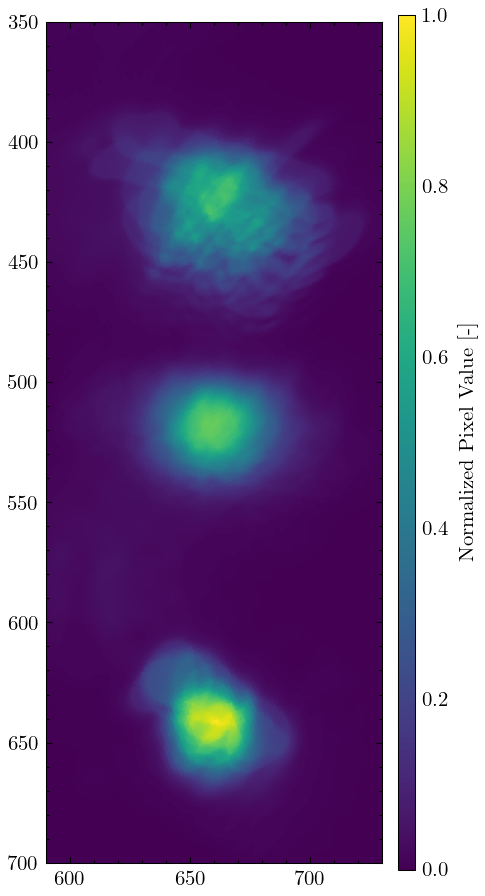

In [11]:
# image_1g = samples_1g[500].load()

focal_cmd = 94.76
focal_cmds = np.unique([x.command for x in samples_0g])
#[ 70.    70.63  71.27  71.9   72.54  73.17  73.81  74.44  75.08  75.71
#  76.35  76.98  77.62  78.25  78.89  79.52  80.16  80.79  81.43  82.06
#  82.7   83.33  83.97  84.6   85.24  85.87  86.51  87.14  87.78  88.41
#  89.05  89.68  90.32  90.95  91.59  92.22  92.86  93.49  94.13  94.76
#  95.4   96.03  96.67  97.3   97.94  98.57  99.21  99.84 100.48 101.11
# 101.75 102.38 103.02 103.65 104.29 104.92 105.56 106.19 106.83 107.46
# 108.1  108.73 109.37 110.  ]
focal_samples_1g = [x for x in samples_1g if x.command == focal_cmd]
focal_samples_0g = [x for x in samples_0g if x.command == focal_cmd]
focal_samples_hg = [x for x in samples_hg if x.command == focal_cmd]
print(f"0g: {len(focal_samples_0g)}, 1g: {len(focal_samples_1g)}, hg: {len(focal_samples_hg)}")

img = (np.mean([x.load() for x in focal_samples_0g], 0) + np.mean([x.load() for x in focal_samples_hg], 0) +np.mean([x.load() for x in focal_samples_1g], 0))
img = ndimage.rotate(img, 23.6 + 180)
img = img/np.max(img)
plt.figure(figsize=(3.25, 6))
plt.imshow(img)
# plt.axis('equal')
plt.tight_layout()
plt.xlim(570+20, 750-20)
plt.ylim(700, 350)
cb1 = plt.colorbar(fraction=0.1, pad=0.04, aspect=50)
cb1.set_label("Normalized Pixel Value [-]")
plt.grid()
plt.savefig("optotune_zerog_spots.png", dpi=600)
plt.show()

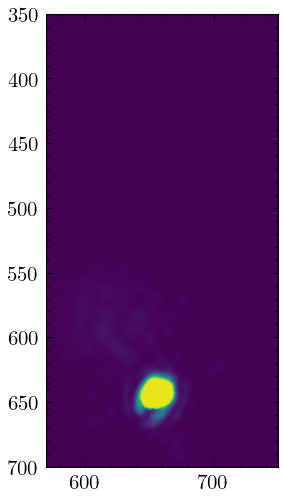

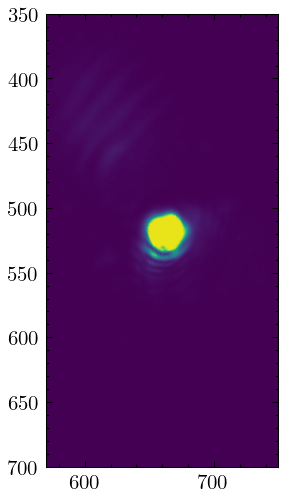

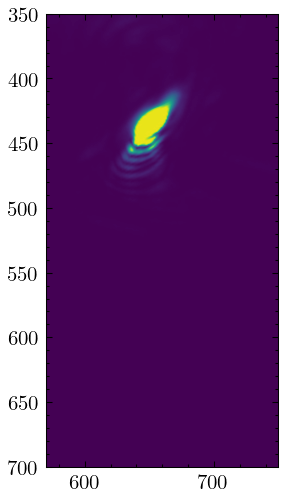

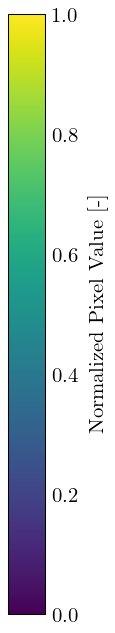

In [14]:
# spot_sample_n = 3

spot_img = focal_samples_0g[3].load()
spot_img = ndimage.rotate(spot_img, 23.6 + 180)
plt.figure(figsize=(2,4))
plt.imshow(spot_img/np.max(spot_img),interpolation='bicubic')
plt.axis('equal')
plt.xlim(570, 750)
plt.ylim(700, 350)
plt.grid()
plt.savefig("spot_opto_0g.pdf")
plt.show()

spot_img = focal_samples_1g[4].load()
spot_img = ndimage.rotate(spot_img, 23.6 + 180)
plt.figure(figsize=(2,4))
plt.imshow(spot_img/np.max(spot_img),interpolation='bicubic')
plt.axis('equal')
# plt.yticks([])
plt.xlim(570, 750)
plt.ylim(700, 350)
plt.grid()
plt.savefig("spot_opto_1g.pdf")
plt.show()

spot_img = focal_samples_hg[5].load()
spot_img = ndimage.rotate(spot_img, 23.6 + 180)
plt.figure(figsize=(2,4))
plt.imshow(spot_img/np.max(spot_img),interpolation='bicubic')
plt.axis('equal')
# plt.yticks([])
plt.xlim(570, 750)
plt.ylim(700, 350)
plt.grid()
plt.savefig("spot_opto_hg.pdf")
plt.show()

fig = plt.figure(figsize=(0.25, 4))
ax1 = fig.add_axes([0.0, 1, 1, 1])
cb1 = matplotlib.colorbar.ColorbarBase(ax1, orientation='vertical')
cb1.set_label("Normalized Pixel Value [-]")
plt.savefig("colorbar_opto.pdf")
plt.show()

In [14]:
L = 136e-3 # mm from lens
com_0g = ndimage.measurements.center_of_mass(np.mean([x.load() for x in focal_samples_0g], 0))
com_1g = ndimage.measurements.center_of_mass(np.mean([x.load() for x in focal_samples_1g], 0))
com_hg = ndimage.measurements.center_of_mass(np.mean([x.load() for x in focal_samples_hg], 0))
print(com_0g)
print(com_1g)
print(com_hg)

# print(1000 * (com_0g[0] - com_1g[0]) * (2 * 2.2e-6) / (L))
# print(1000 * (com_0g[0] - com_hg[0]) * (2 * 2.2e-6) / (L))

print(1000 * np.sqrt((com_0g[0] - com_1g[0]) ** 2 + (com_0g[1] - com_1g[1]) ** 2) * (2 * 2.2e-6) / (L))
print(1000 * np.sqrt((com_0g[0] - com_hg[0]) ** 2 + (com_0g[1] - com_1g[1]) ** 2) * (2 * 2.2e-6) / (L))
# plt.imshow(np.mean([x.load() for x in focal_samples_1g], 0))

(602.8040981652749, 737.9755506702453, 0.0)
(718.4910194666832, 690.358338937502, 0.0)
(792.0570525466753, 650.8488816634278, 0.0)
4.047463189679495
6.313722649438382


In [15]:
# calculate sd and mean for each spot area?
spot_mean_0g = []
spot_sd_0g = []

spot_mean_hg = []
spot_sd_hg = []
     
spot_mean_1g = []
spot_sd_1g = []

spots_0g = []
spots_hg = []
spots_1g = []

focal_cmds = np.unique([x.command for x in samples_0g])

for c in focal_cmds:
    f_samples_0g = [x for x in samples_0g if x.command == c]
    f_samples_hg = [x for x in samples_hg if x.command == c]
    f_samples_1g = [x for x in samples_1g if x.command == c]
    
    appended_spots_0g = [(x.command, np.sqrt(x.spot_area())) for x in f_samples_0g]
    spots_0g += appended_spots_0g
    
    appended_spots_hg = [(x.command, np.sqrt(x.spot_area())) for x in f_samples_hg]
    spots_hg += appended_spots_hg
    
    appended_spots_1g = [(x.command, np.sqrt(x.spot_area())) for x in f_samples_1g if x.spot_area() > 0]
    spots_1g += appended_spots_1g
    
    spot_mean_0g.append(np.mean([x[1] for x in appended_spots_0g]))
    spot_sd_0g.append(np.std([x[1] for x in appended_spots_0g]))
    
    spot_mean_hg.append(np.mean([x[1] for x in appended_spots_hg]))
    spot_sd_hg.append(np.std([x[1] for x in appended_spots_hg]))
    
    spot_mean_1g.append(np.mean([x[1] for x in appended_spots_1g]))
    spot_sd_1g.append(np.std([x[1] for x in appended_spots_1g]))
    
# this is stupid
spot_mean_0g = np.array(spot_mean_0g)
spot_sd_0g = np.array(spot_sd_0g)
spot_mean_hg = np.array(spot_mean_hg)
spot_sd_hg = np.array(spot_sd_hg)
spot_mean_1g = np.array(spot_mean_1g)
spot_sd_1g = np.array(spot_sd_1g)

[ 0.79198999 20.06460401  0.04649207  0.35399281]
[ 0.40459587 10.58405962  0.0244821   0.16890892]
[ 1.06787511 24.00554364  0.07124808  0.42609475]
[43.26139185 72.10182121 94.25896372 16.15727007]
[44.0382958  81.56216784 94.90358278 14.83745617]
[46.43950473 55.82436717 94.4833598  12.77135922]


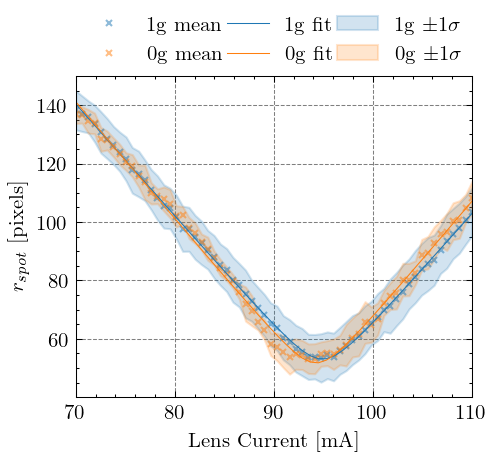

In [32]:
def hyperb(x, a, b, c, d):
    return a + np.sqrt(b + d * np.square(x-c))

# do a curve fit...
cmds_0g = np.array([x[0] for x in spots_0g])
sqarea_0g = np.array([x[1] for x in spots_0g])

cmds_hg = np.array([x[0] for x in spots_hg])
sqarea_hg = np.array([x[1] for x in spots_hg])

cmds_1g = np.array([x[0] for x in spots_1g])
sqarea_1g = np.array([x[1] for x in spots_1g])
# print(hyperb(cmds_0g, 1, 1, 1))
# print(cmds_0g.shape)
# print(sqarea_0g.shape)
popt_0g, pcov_0g = curve_fit(hyperb, cmds_0g, sqarea_0g, p0=[60, 1, 92, 10])
popt_hg, pcov_hg = curve_fit(hyperb, cmds_hg, sqarea_hg, p0=[60, 1, 92, 10])
popt_1g, pcov_1g = curve_fit(hyperb, cmds_1g, sqarea_1g, p0=[60, 1, 92, 10])

plt.figure(figsize=(3.5, 3.25))
linsp = np.linspace(70, 110)
plt.plot(focal_cmds, spot_mean_1g, 'x', alpha=0.5, color="tab:blue",markersize=2.5)
plt.plot(focal_cmds, spot_mean_0g, 'x', alpha=0.5, color="tab:orange",markersize=2.5)
# plt.plot(focal_cmds, spot_mean_hg, 'x', alpha=0.5)

# plt.plot(linsp, hyperb(linsp, 60, 1, 92, 10))
plt.plot(linsp, hyperb(linsp, *popt_1g), color="tab:blue")
plt.plot(linsp, hyperb(linsp, *popt_0g), color="tab:orange")
# plt.plot(linsp, hyperb(linsp, *popt_hg), color="tab:green")

print(np.sqrt(np.diag(pcov_0g)))
print(np.sqrt(np.diag(pcov_1g)))
print(np.sqrt(np.diag(pcov_hg)))

print(popt_0g)
print(popt_1g)
print(popt_hg)

# plt.plot(focal_cmds,(spot_mean_1g), 'x')
plt.fill_between(focal_cmds, (spot_mean_1g + spot_sd_1g), (spot_mean_1g - spot_sd_1g), alpha=0.2, color="tab:blue")
# plt.plot(focal_cmds, (spot_mean_0g), 'x')
plt.fill_between(focal_cmds, (spot_mean_0g + spot_sd_0g), (spot_mean_0g - spot_sd_0g), alpha=0.2, color="tab:orange")
# plt.plot(focal_cmds, (spot_mean_hg), 'x')
# plt.fill_between(focal_cmds, (spot_mean_hg + spot_sd_hg), (spot_mean_hg - spot_sd_hg), alpha=0.2)
plt.tight_layout()
# plt.grid()
plt.xlim(70, 110)

plt.xlabel("Lens Current [mA]")
plt.ylabel("$r_{spot}$ [pixels]")
plt.legend(["1g mean", "0g mean", "1g fit", "0g fit", "1g $\pm 1 \sigma$", "0g $\pm 1 \sigma$"], loc='lower left', bbox_to_anchor=(-0.015, 0.98, 1.035, 0.1), ncol=3, mode="expand",frameon=False)
plt.tight_layout()
plt.savefig("r_spot_optotune.pdf")           
plt.show()

In [81]:
print(popt_0g)
print(popt_1g)

[43.26139185 72.10182121 94.25896372 16.15727007]
[44.0382958  81.56216784 94.90358278 14.83745617]


4.13318007229977


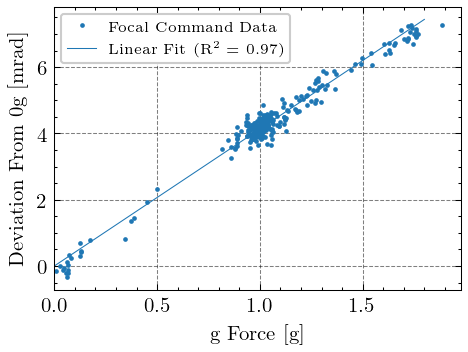

In [49]:
focal_samples = [x for x in samples if x.command == focal_cmd]

data_regress = [np.array([x.a for x in focal_samples]) , np.array([1000 * (com_0g[0] - ndimage.measurements.center_of_mass(ndimage.rotate(x.load(), 23.6 + 180))[0]) * (2 * 2.2e-6) / (L) for x in focal_samples])]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(data_regress[0], data_regress[1])

bias = -intercept
print(slope)
# plt.figure(figsize=(3.5, 3.25))
plt.plot(data_regress[0], data_regress[1] + bias, '.', markersize=2.5, alpha=1, color='tab:blue')
plt.plot([0, 1.8], [intercept + bias, intercept + bias + slope * 1.8], color='tab:blue')
plt.legend(["Focal Command Data", f"Linear Fit (R$^2$ = {r_value**2:.2f})"], fontsize='x-small')
plt.xlim(0)
plt.xlabel("g Force [g]")
plt.ylabel("Deviation From 0g [mrad]")
plt.savefig("optotune_regression.pdf")
plt.show()

In [ ]:
t = [x.time for x in samples]
plt.hist(np.diff(t[1000::]), density=True, bins=50)
plt.tight_layout()
# plt.ylim(-0.2, 0.2)
plt.show()
# plt.plot([x.pressure for x in samples][1000::])

In [ ]:
# samples per command point
sample_counts = [len([y for y in samples_1g if y.command == c]) for c in focal_cmds]

# plt.bar(focal_cmds, sample_counts)
plt.plot(focal_cmds, np.sqrt(spot_mean_1g))
plt.tight_layout()
plt.grid()
plt.xlim(70, 110)
plt.show()


In [ ]:
# temperature drift vs spot size...
plt.plot([x.temperature for x in focal_samples_1g], [np.sqrt(x.spot_area()) for x in focal_samples_1g], 'x')
plt.plot([x.temperature for x in focal_samples_0g], [np.sqrt(x.spot_area()) for x in focal_samples_0g], 'x')
plt.plot([x.temperature for x in focal_samples_hg], [np.sqrt(x.spot_area()) for x in focal_samples_hg], 'x')
plt.grid()
plt.show()

In [ ]:
plt.hist([x.temperature for x in samples_1g], bins=np.arange(26, 36, 1), density=True, color='tab:blue')
plt.grid()
plt.ylim([0, 0.75])
plt.xlabel("Temperature [°C]")
plt.ylabel("Proportion [-]")
plt.tight_layout()
plt.savefig("optotune_temp_histogram_1g.pdf")
plt.show()
plt.hist([x.temperature for x in samples_0g], bins=np.arange(26, 36, 1), density=True, color='tab:orange')
plt.grid()
plt.ylim([0, 0.75])
plt.xlabel("Temperature [°C]")
plt.ylabel("Proportion [-]")
plt.tight_layout()
plt.savefig("optotune_temp_histogram_0g.pdf")
plt.show()
plt.hist([x.temperature for x in samples_hg],bins=np.arange(26, 36, 1), density=True, color='tab:green')
plt.grid()
plt.ylim([0, 0.5])
plt.xlabel("Temperature [°C]")
plt.ylabel("Proportion [-]")
plt.show()

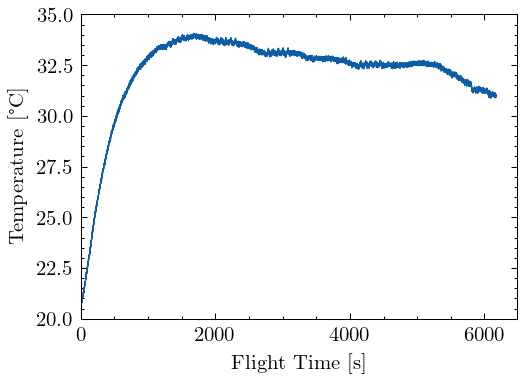

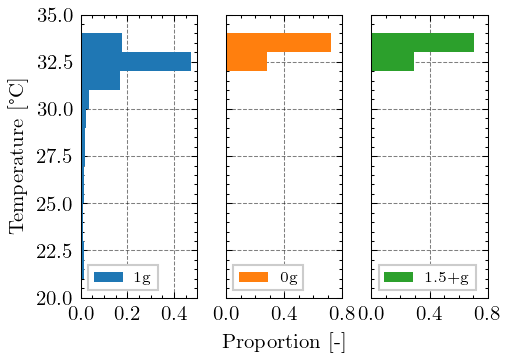

In [19]:
plt.plot([x.time - t0 for x in samples], [x.temperature for x in samples])
# plt.plot([x.time - t0 for x in samples_1g], [x.temperature for x in samples_1g], '.')
# plt.plot([x.time - t0 for x in samples_hg], [x.temperature for x in samples_hg], '.')
# plt.plot(np.load("time_optotune.npy"), np.load("temp_optotune.npy"))
plt.tight_layout()
# plt.legend(["Corning Varioptic", "Optotune"], loc='lower right')
plt.grid()
plt.ylabel("Temperature [°C]")
plt.xlabel("Flight Time [s]")
plt.xlim(0)
plt.ylim(20, 35)
plt.savefig('temperature_opto.pdf')  
plt.show()

plt.subplots(1,3, constrained_layout=False)
plt.subplot(1, 3, 1)
plt.hist([x.temperature for x in samples_1g], bins=np.arange(20, 36, 1), density=True, color='tab:blue', orientation="horizontal")
# plt.grid()
plt.ylim([20, 35])
plt.ylabel("Temperature [°C]")
# plt.xlabel("Proportion [-]")
plt.legend(["1g"], loc='lower left', fancybox=False, fontsize="x-small")
plt.xticks([0, 0.2, 0.4])
# plt.tight_layout()
# plt.savefig("corning_temp_histogram_1g.pdf")
plt.subplot(1, 3, 2)
plt.hist([x.temperature for x in samples_0g], bins=np.arange(20, 36, 1), density=True, color='tab:orange', orientation="horizontal")
# plt.grid()
plt.ylim([20, 35])
# plt.ylabel("Temperature [°C]")
plt.xlabel("Proportion [-]")
plt.legend(["0g"], loc='lower left', fancybox=False, fontsize="x-small")
plt.xticks([0, 0.4, 0.8])
frame1 = plt.gca()
# frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.subplot(1, 3, 3)
plt.hist([x.temperature for x in samples_hg], bins=np.arange(20, 36, 1), density=True, color='tab:green', orientation="horizontal")
# plt.grid()
plt.ylim([20, 35])
# plt.ylabel("Temperature [°C]")
# plt.xlabel("Proportion [-]")
plt.legend(["1.5+g"], loc='lower left', fancybox=False, fontsize="x-small")
plt.xticks([0, 0.4, 0.8])
frame1 = plt.gca()
# frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
plt.subplots_adjust(wspace=0.25)
plt.savefig("temp_histo_opto.pdf")
plt.show()
# plt.hist([x.temperature for x in samples_0g], bins=np.arange(26, 32.5, 1), density=True, color='tab:orange')
# plt.grid()
# plt.ylim([0, 0.5])
# plt.xlabel("Temperature [°C]")
# plt.ylabel("Proportion [-]")
# plt.tight_layout()
# plt.savefig("corning_temp_histogram_0g.pdf")
# plt.show()
# plt.hist([x.temperature for x in samples_hg],bins=np.arange(26, 32.5, 1), density=True, color='tab:green')
# plt.tight_layout()
# plt.grid()
# plt.ylim([0, 0.5])
# plt.xlabel("Temperature [°C]")
# plt.ylabel("Proportion [-]")
# plt.show()